
# Evaluation of outlier detection estimators

This example compares two outlier detection algorithms, namely
`local_outlier_factor` (LOF) and `isolation_forest` (IForest), on
real-world datasets available in :class:`sklearn.datasets`. The goal is to show
that different algorithms perform well on different datasets and contrast their
training speed and sensitivity to hyperparameters.

The algorithms are trained (without labels) on the whole dataset assumed to
contain outliers.

1. The ROC curves are computed using knowledge of the ground-truth labels
and displayed using :class:`~sklearn.metrics.RocCurveDisplay`.

2. The performance is assessed in terms of the ROC-AUC.


In [1]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

## Dataset preprocessing and model training

Different outlier detection models require different preprocessing. In the
presence of categorical variables,
:class:`~sklearn.preprocessing.OrdinalEncoder` is often a good strategy for
tree-based models such as :class:`~sklearn.ensemble.IsolationForest`, whereas
neighbors-based models such as :class:`~sklearn.neighbors.LocalOutlierFactor`
would be impacted by the ordering induced by ordinal encoding. To avoid
inducing an ordering, on should rather use
:class:`~sklearn.preprocessing.OneHotEncoder`.

Neighbors-based models may also require scaling of the numerical features (see
for instance `neighbors_scaling`). In the presence of outliers, a good
option is to use a :class:`~sklearn.preprocessing.RobustScaler`.



In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    RobustScaler,
)


def make_estimator(name, categorical_columns=None, iforest_kw=None, lof_kw=None):
    """Create an outlier detection estimator based on its name."""
    if name == "LOF":
        outlier_detector = LocalOutlierFactor(**(lof_kw or {}))
        if categorical_columns is None:
            preprocessor = RobustScaler()
        else:
            preprocessor = ColumnTransformer(
                transformers=[("categorical", OneHotEncoder(), categorical_columns)],
                remainder=RobustScaler(),
            )
    else:  # name == "IForest"
        outlier_detector = IsolationForest(**(iforest_kw or {}))
        if categorical_columns is None:
            preprocessor = None
        else:
            ordinal_encoder = OrdinalEncoder(
                handle_unknown="use_encoded_value", unknown_value=-1
            )
            preprocessor = ColumnTransformer(
                transformers=[
                    ("categorical", ordinal_encoder, categorical_columns),
                ],
                remainder="passthrough",
            )

    return make_pipeline(preprocessor, outlier_detector)

The following `fit_predict` function returns the average outlier score of X.



In [ ]:
from time import perf_counter


def fit_predict(estimator, X):
    tic = perf_counter()
    if estimator[-1].__class__.__name__ == "LocalOutlierFactor":
        estimator.fit(X)
        y_score = estimator[-1].negative_outlier_factor_
    else:  # "IsolationForest"
        y_score = estimator.fit(X).decision_function(X)
    toc = perf_counter()
    print(f"Duration for {model_name}: {toc - tic:.2f} s")
    return y_score

On the rest of the example we process one dataset per section. After loading
the data, the targets are modified to consist of two classes: 0 representing
inliers and 1 representing outliers. Due to computational constraints of the
scikit-learn documentation, the sample size of some datasets is reduced using
a stratified :class:`~sklearn.model_selection.train_test_split`.

Furthermore, we set `n_neighbors` to match the expected number of anomalies
`expected_n_anomalies = n_samples * expected_anomaly_fraction`. This is a good
heuristic as long as the proportion of outliers is not very low, the reason
being that `n_neighbors` should be at least greater than the number of samples
in the less populated cluster (see
`sphx_glr_auto_examples_neighbors_plot_lof_outlier_detection.py`).

### KDDCup99 - SA dataset

The `kddcup99_dataset` was generated using a closed network and
hand-injected attacks. The SA dataset is a subset of it obtained by simply
selecting all the normal data and an anomaly proportion of around 3%.



In [19]:
import numpy as np

from sklearn.datasets import fetch_kddcup99
from sklearn.model_selection import train_test_split

X, y = fetch_kddcup99(
    subset="SA", percent10=True, random_state=42, return_X_y=True, as_frame=True
)
y = (y != b"normal.").astype(np.int32)
X, _, y, _ = train_test_split(X, y, train_size=0.1, stratify=y, random_state=42)

n_samples, anomaly_frac = X.shape[0], y.mean()
print(f"{n_samples} datapoints with {y.sum()} anomalies ({anomaly_frac:.02%})")

10065 datapoints with 338 anomalies (3.36%)


The SA dataset contains 41 features out of which 3 are categorical:
"protocol_type", "service" and "flag".



In [20]:
y_true = {}
y_score = {"LOF": {}, "IForest": {}}
model_names = ["LOF", "IForest"]
cat_columns = ["protocol_type", "service", "flag"]

y_true["KDDCup99 - SA"] = y
for model_name in model_names:
    model = make_estimator(
        name=model_name,
        categorical_columns=cat_columns,
        lof_kw={"n_neighbors": int(n_samples * anomaly_frac)},
        iforest_kw={"random_state": 42},
    )
    y_score[model_name]["KDDCup99 - SA"] = fit_predict(model, X)

Duration for LOF: 0.80 s
Duration for IForest: 0.36 s


### Forest covertypes dataset

The `covtype_dataset` is a multiclass dataset where the target is the
dominant species of tree in a given patch of forest. It contains 54 features,
some of which ("Wilderness_Area" and "Soil_Type") are already binary encoded.
Though originally meant as a classification task, one can regard inliers as
samples encoded with label 2 and outliers as those with label 4.



In [21]:
from sklearn.datasets import fetch_covtype

X, y = fetch_covtype(return_X_y=True, as_frame=True)
s = (y == 2) + (y == 4)
X = X.loc[s]
y = y.loc[s]
y = (y != 2).astype(np.int32)

X, _, y, _ = train_test_split(X, y, train_size=0.05, stratify=y, random_state=42)
X_forestcover = X  # save X for later use

n_samples, anomaly_frac = X.shape[0], y.mean()
print(f"{n_samples} datapoints with {y.sum()} anomalies ({anomaly_frac:.02%})")

14302 datapoints with 137 anomalies (0.96%)


In [22]:
y_true["forestcover"] = y
for model_name in model_names:
    model = make_estimator(
        name=model_name,
        lof_kw={"n_neighbors": int(n_samples * anomaly_frac)},
        iforest_kw={"random_state": 42},
    )
    y_score[model_name]["forestcover"] = fit_predict(model, X)

Duration for LOF: 0.80 s
Duration for IForest: 0.26 s


### Ames Housing dataset

The [Ames housing dataset](http://www.openml.org/d/43926) is originally a
regression dataset where the target are sales prices of houses in Ames, Iowa.
Here we convert it into an outlier detection problem by regarding houses with
price over 70 USD/sqft. To make the problem easier, we drop intermediate
prices between 40 and 70 USD/sqft.



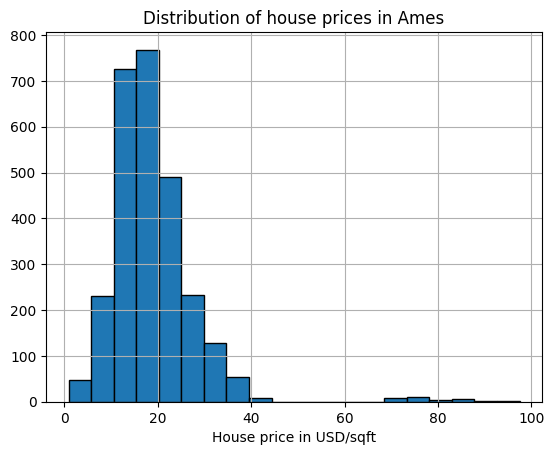

In [26]:
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

X, y = fetch_openml(name="ames_housing", version=1, return_X_y=True, as_frame=True)
y = y.div(X["Lot_Area"])

# None values in pandas 1.5.1 were mapped to np.nan in pandas 2.0.1
X["Misc_Feature"] = X["Misc_Feature"].cat.add_categories("NoInfo").fillna("NoInfo")
X["Mas_Vnr_Type"] = X["Mas_Vnr_Type"].cat.add_categories("NoInfo").fillna("NoInfo")

X.head()  # Display the first few rows of the dataset
y.head()  # Display the first few rows of the target variable

X.drop(columns="Lot_Area", inplace=True)
mask = (y < 40) | (y > 70)
X = X.loc[mask]
y = y.loc[mask]
y.hist(bins=20, edgecolor="black")
plt.xlabel("House price in USD/sqft")
_ = plt.title("Distribution of house prices in Ames")

In [27]:
y = (y > 70).astype(np.int32)

n_samples, anomaly_frac = X.shape[0], y.mean()
print(f"{n_samples} datapoints with {y.sum()} anomalies ({anomaly_frac:.02%})")

2714 datapoints with 30 anomalies (1.11%)


The dataset contains 46 categorical features. In this case it is easier use a
:class:`~sklearn.compose.make_column_selector` to find them instead of passing
a list made by hand.



In [28]:
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include="category")
cat_columns = categorical_columns_selector(X)

y_true["ames_housing"] = y
for model_name in model_names:
    model = make_estimator(
        name=model_name,
        categorical_columns=cat_columns,
        lof_kw={"n_neighbors": int(n_samples * anomaly_frac)},
        iforest_kw={"random_state": 42},
    )
    y_score[model_name]["ames_housing"] = fit_predict(model, X)

Duration for LOF: 0.97 s
Duration for IForest: 0.31 s


### Cardiotocography dataset

The [Cardiotocography dataset](http://www.openml.org/d/1466) is a multiclass
dataset of fetal cardiotocograms, the classes being the fetal heart rate (FHR)
pattern encoded with labels from 1 to 10. Here we set class 3 (the minority
class) to represent the outliers. It contains 30 numerical features, some of
which are binary encoded and some are continuous.



In [29]:
X, y = fetch_openml(name="cardiotocography", version=1, return_X_y=True, as_frame=False)
X_cardiotocography = X  # save X for later use
s = y == "3"
y = s.astype(np.int32)

n_samples, anomaly_frac = X.shape[0], y.mean()
print(f"{n_samples} datapoints with {y.sum()} anomalies ({anomaly_frac:.02%})")

2126 datapoints with 53 anomalies (2.49%)


In [30]:
y_true["cardiotocography"] = y
for model_name in model_names:
    model = make_estimator(
        name=model_name,
        lof_kw={"n_neighbors": int(n_samples * anomaly_frac)},
        iforest_kw={"random_state": 42},
    )
    y_score[model_name]["cardiotocography"] = fit_predict(model, X)

Duration for LOF: 0.10 s
Duration for IForest: 0.15 s


## Plot and interpret results

The algorithm performance relates to how good the true positive rate (TPR) is
at low value of the false positive rate (FPR). The best algorithms have the
curve on the top-left of the plot and the area under curve (AUC) close to 1.
The diagonal dashed line represents a random classification of outliers and
inliers.



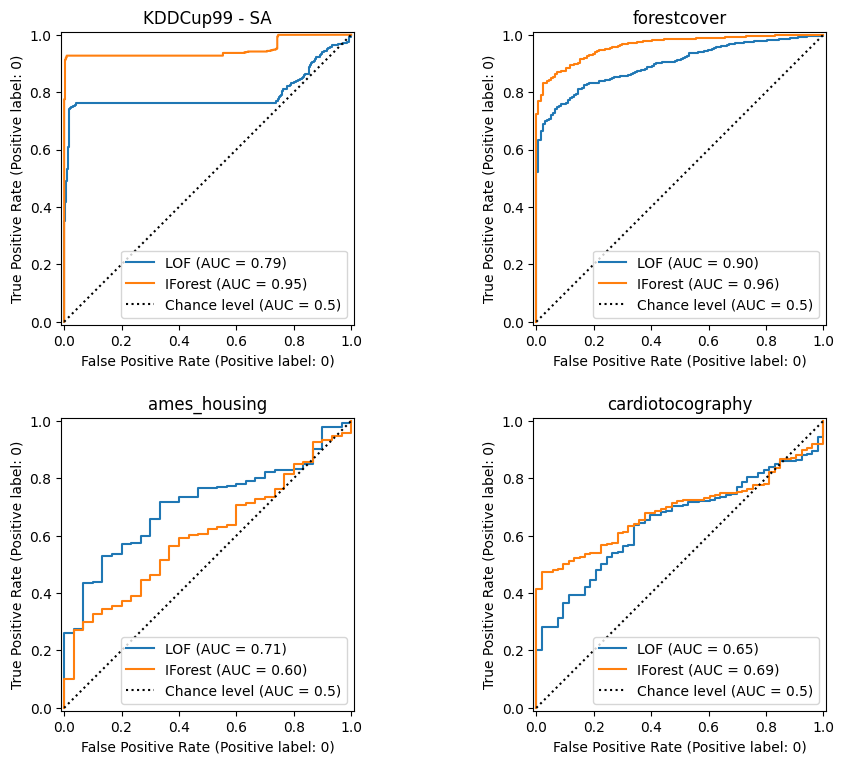

In [31]:
import math

from sklearn.metrics import RocCurveDisplay

cols = 2
pos_label = 0  # mean 0 belongs to positive class
datasets_names = y_true.keys()
rows = math.ceil(len(datasets_names) / cols)

fig, axs = plt.subplots(nrows=rows, ncols=cols, squeeze=False, figsize=(10, rows * 4))

for ax, dataset_name in zip(axs.ravel(), datasets_names):
    for model_idx, model_name in enumerate(model_names):
        display = RocCurveDisplay.from_predictions(
            y_true[dataset_name],
            y_score[model_name][dataset_name],
            pos_label=pos_label,
            name=model_name,
            ax=ax,
            plot_chance_level=(model_idx == len(model_names) - 1),
            chance_level_kw={"linestyle": ":"},
        )
    ax.set_title(dataset_name)
_ = plt.tight_layout(pad=2.0)  # spacing between subplots

We observe that once the number of neighbors is tuned, LOF and IForest perform
similarly in terms of ROC AUC for the forestcover and cardiotocography
datasets. The score for IForest is slightly better for the SA dataset and LOF
performs considerably better on the Ames housing dataset than IForest.

Recall however that Isolation Forest tends to train much faster than LOF on
datasets with a large number of samples. LOF needs to compute pairwise
distances to find nearest neighbors, which has a quadratic complexity with respect
to the number of observations. This can make this method prohibitive on large
datasets.

## Ablation study

In this section we explore the impact of the hyperparameter `n_neighbors` and
the choice of scaling the numerical variables on the LOF model. Here we use
the `covtype_dataset` dataset as the binary encoded categories introduce
a natural scale of euclidean distances between 0 and 1. We then want a scaling
method to avoid granting a privilege to non-binary features and that is robust
enough to outliers so that the task of finding them does not become too
difficult.



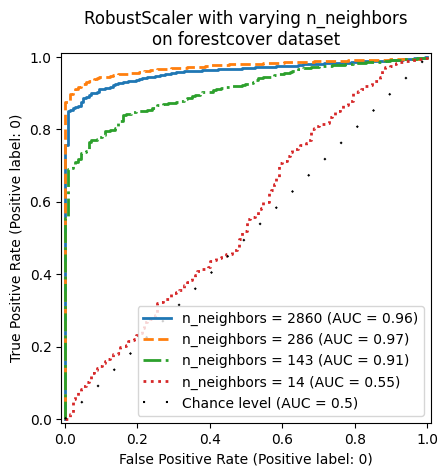

In [32]:
X = X_forestcover
y = y_true["forestcover"]

n_samples = X.shape[0]
n_neighbors_list = (n_samples * np.array([0.2, 0.02, 0.01, 0.001])).astype(np.int32)
model = make_pipeline(RobustScaler(), LocalOutlierFactor())

linestyles = ["solid", "dashed", "dashdot", ":", (5, (10, 3))]

fig, ax = plt.subplots()
for model_idx, (linestyle, n_neighbors) in enumerate(zip(linestyles, n_neighbors_list)):
    model.set_params(localoutlierfactor__n_neighbors=n_neighbors)
    model.fit(X)
    y_score = model[-1].negative_outlier_factor_
    display = RocCurveDisplay.from_predictions(
        y,
        y_score,
        pos_label=pos_label,
        name=f"n_neighbors = {n_neighbors}",
        ax=ax,
        plot_chance_level=(model_idx == len(n_neighbors_list) - 1),
        chance_level_kw={"linestyle": (0, (1, 10))},
        curve_kwargs=dict(linestyle=linestyle, linewidth=2),
    )
_ = ax.set_title("RobustScaler with varying n_neighbors\non forestcover dataset")

We observe that the number of neighbors has a big impact on the performance of
the model. If one has access to (at least some) ground truth labels, it is
then important to tune `n_neighbors` accordingly. A convenient way to do so is
to explore values for `n_neighbors` of the order of magnitud of the expected
contamination.



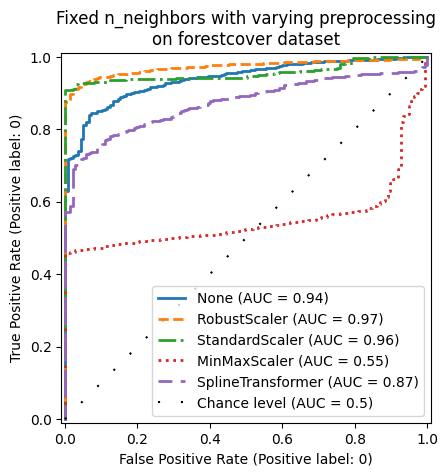

In [33]:
from sklearn.preprocessing import MinMaxScaler, SplineTransformer, StandardScaler

preprocessor_list = [
    None,
    RobustScaler(),
    StandardScaler(),
    MinMaxScaler(),
    SplineTransformer(),
]
expected_anomaly_fraction = 0.02
lof = LocalOutlierFactor(n_neighbors=int(n_samples * expected_anomaly_fraction))

fig, ax = plt.subplots()
for model_idx, (linestyle, preprocessor) in enumerate(
    zip(linestyles, preprocessor_list)
):
    model = make_pipeline(preprocessor, lof)
    model.fit(X)
    y_score = model[-1].negative_outlier_factor_
    display = RocCurveDisplay.from_predictions(
        y,
        y_score,
        pos_label=pos_label,
        name=str(preprocessor).split("(")[0],
        ax=ax,
        plot_chance_level=(model_idx == len(preprocessor_list) - 1),
        chance_level_kw={"linestyle": (0, (1, 10))},
        curve_kwargs=dict(linestyle=linestyle, linewidth=2),
    )
_ = ax.set_title("Fixed n_neighbors with varying preprocessing\non forestcover dataset")

On the one hand, :class:`~sklearn.preprocessing.RobustScaler` scales each
feature independently by using the interquartile range (IQR) by default, which
is the range between the 25th and 75th percentiles of the data. It centers the
data by subtracting the median and then scale it by dividing by the IQR. The
IQR is robust to outliers: the median and interquartile range are less
affected by extreme values than the range, the mean and the standard
deviation. Furthermore, :class:`~sklearn.preprocessing.RobustScaler` does not
squash marginal outlier values, contrary to
:class:`~sklearn.preprocessing.StandardScaler`.

On the other hand, :class:`~sklearn.preprocessing.MinMaxScaler` scales each
feature individually such that its range maps into the range between zero and
one. If there are outliers in the data, they can skew it towards either the
minimum or maximum values, leading to a completely different distribution of
data with large marginal outliers: all non-outlier values can be collapsed
almost together as a result.

We also evaluated no preprocessing at all (by passing `None` to the pipeline),
:class:`~sklearn.preprocessing.StandardScaler` and
:class:`~sklearn.preprocessing.SplineTransformer`. Please refer to their
respective documentation for more details.

Note that the optimal preprocessing depends on the dataset, as shown below:



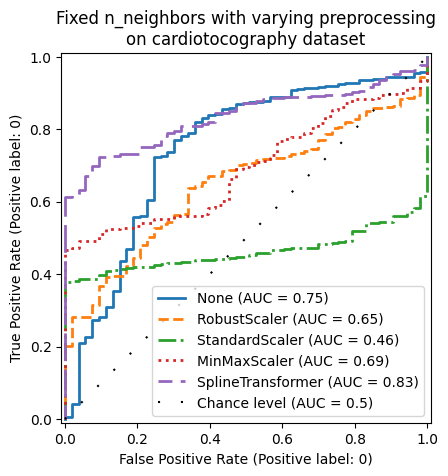

In [34]:
X = X_cardiotocography
y = y_true["cardiotocography"]

n_samples, expected_anomaly_fraction = X.shape[0], 0.025
lof = LocalOutlierFactor(n_neighbors=int(n_samples * expected_anomaly_fraction))

fig, ax = plt.subplots()
for model_idx, (linestyle, preprocessor) in enumerate(
    zip(linestyles, preprocessor_list)
):
    model = make_pipeline(preprocessor, lof)
    model.fit(X)
    y_score = model[-1].negative_outlier_factor_
    display = RocCurveDisplay.from_predictions(
        y,
        y_score,
        pos_label=pos_label,
        name=str(preprocessor).split("(")[0],
        ax=ax,
        plot_chance_level=(model_idx == len(preprocessor_list) - 1),
        chance_level_kw={"linestyle": (0, (1, 10))},
        curve_kwargs=dict(linestyle=linestyle, linewidth=2),
    )
ax.set_title(
    "Fixed n_neighbors with varying preprocessing\non cardiotocography dataset"
)
plt.show()